In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sksurv.ensemble import RandomSurvivalForest
from sksurv.preprocessing import OneHotEncoder
from sksurv.metrics import concordance_index_censored

In [27]:
# Load the dataset
df = pd.read_csv('adult_cancer_survival_2015_2019.csv')

In [28]:
# Display the first few rows of the dataset
print(df.head())

  Diagnosis Year Geography Type Geography Code Geography Name Cancer Site  \
0   2015 to 2019        Country      E92000001        England        Anus   
1   2015 to 2019        Country      E92000001        England        Anus   
2   2015 to 2019        Country      E92000001        England        Anus   
3   2015 to 2019        Country      E92000001        England        Anus   
4   2015 to 2019        Country      E92000001        England        Anus   

    Gender Deprivation Quintile                Stage Age At Diagnosis  \
0  Persons    1 - most deprived  All stages combined         15 to 44   
1  Persons    1 - most deprived  All stages combined         45 to 54   
2  Persons    1 - most deprived  All stages combined         55 to 64   
3  Persons    1 - most deprived  All stages combined         65 to 74   
4  Persons    1 - most deprived  All stages combined         75 to 99   

  Standardisation Type  Years Since Diagnosis  Patients  Survival (%)  \
0   Non - standardised   

In [29]:
# Data Cleaning
df.dropna(inplace=True)

In [30]:
# Convert 'Age At Diagnosis' to a numeric representation (e.g., mean of the range)
def convert_age_range(age_range):
    if age_range == 'All ages':
        return None  # Handle 'All ages' as NaN
    if 'to' in age_range:
        start, end = age_range.split(' to ')
        return (int(start) + int(end)) / 2
    else:
        return int(age_range)

df['Age At Diagnosis'] = df['Age At Diagnosis'].apply(convert_age_range)

In [31]:
# Convert 'Diagnosis Year' to a representative year (e.g., midpoint of the range)
def convert_year_range(year_range):
    if 'to' in year_range:
        start, end = year_range.split(' to ')
        return (int(start) + int(end)) / 2
    else:
        return int(year_range)

df['Diagnosis Year'] = df['Diagnosis Year'].apply(convert_year_range)

In [32]:
# Drop rows where 'Age At Diagnosis' is NaN
df.dropna(subset=['Age At Diagnosis'], inplace=True)

In [33]:
# Descriptive Statistics
descriptive_stats = df.describe()
print(descriptive_stats)

       Diagnosis Year  Age At Diagnosis  Years Since Diagnosis      Patients  \
count         14553.0      14553.000000           14553.000000  14553.000000   
mean           2017.0         60.647702               2.812341   2474.222222   
std               0.0         19.108672               1.382678   5749.171386   
min            2017.0         29.500000               1.000000     10.000000   
25%            2017.0         49.500000               2.000000    274.000000   
50%            2017.0         59.500000               3.000000    762.000000   
75%            2017.0         69.500000               4.000000   2188.000000   
max            2017.0         92.000000               5.000000  91173.000000   

       Survival (%)  Lower 95% CI  Upper 95% CI  
count  14553.000000  14553.000000  14553.000000  
mean      64.174802     60.042184     68.306542  
std       27.037123     27.485236     27.017744  
min        1.600000      1.000000      2.000000  
25%       43.800000     37.60

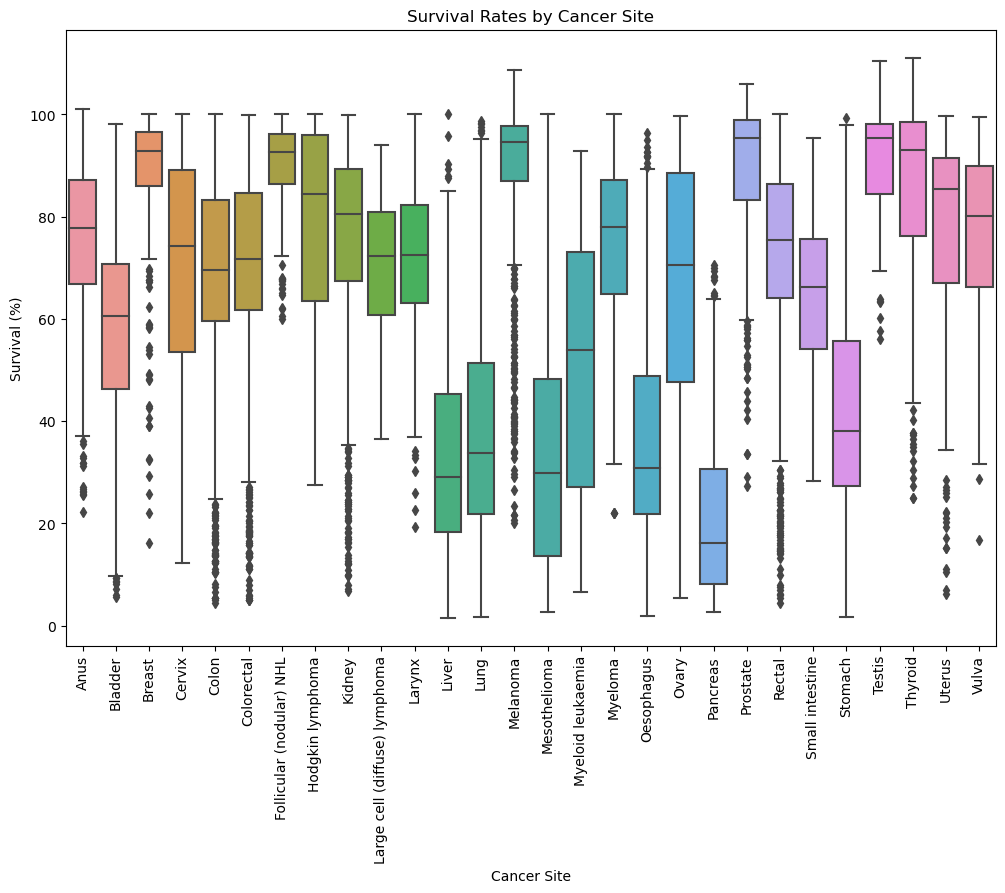

In [34]:
# Visualization: Survival Rates by Cancer Site
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='Cancer Site', y='Survival (%)')
plt.xticks(rotation=90)
plt.title('Survival Rates by Cancer Site')
plt.show()

### Key Observations:

1) High Survival Rates:

Thyroid, Testis, Prostate, and Breast cancers tend to have higher survival rates, with medians close to or above 80%.

2) Low Survival Rates:

Pancreas, Liver, and Lung cancers have lower median survival rates, with many cases below 50%.

3)Variation:

Some cancer types, like Melanoma, Colon, and Breast, show a wide range of survival rates, indicating variability in patient outcomes possibly due to factors like stage at diagnosis, treatment types, and patient demographics.

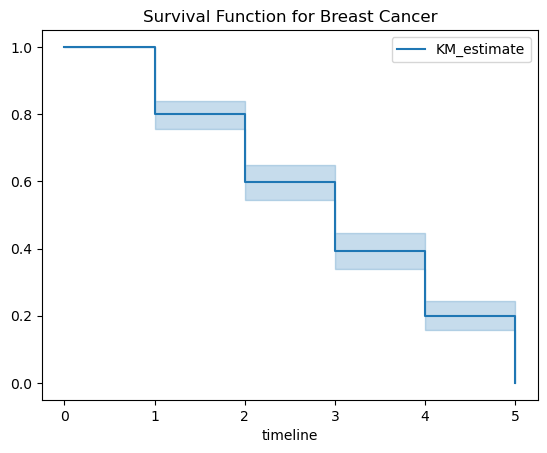

In [35]:
#Kaplan-Meier Analysis for different cancer types
cancer_type = 'Breast'
df_breast = df[df['Cancer Site'] == cancer_type]

kmf = KaplanMeierFitter()
#Assuming 'Years Since Diagnosis' is our duration column and 'Survival (%)' < 100 is the event
kmf.fit(df_breast['Years Since Diagnosis'], event_observed=(df_breast['Survival (%)'] < 100))

kmf.plot_survival_function()
plt.title(f'Survival Function for {cancer_type} Cancer')
plt.show()

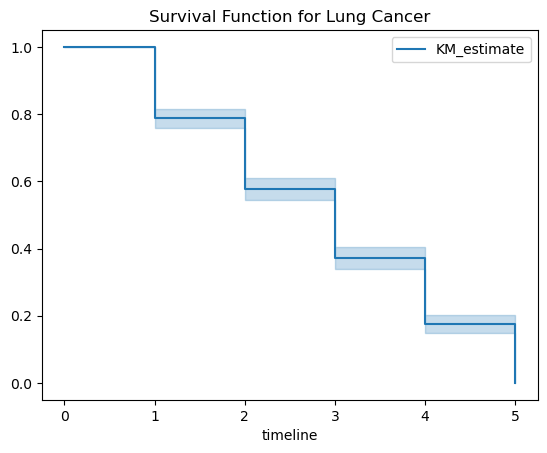

In [37]:
cancer_type = 'Lung'
df_lung = df[df['Cancer Site'] == cancer_type]

kmf = KaplanMeierFitter()
# Assuming 'Years Since Diagnosis' is our duration column and 'Survival (%)' < 100 is the event
kmf.fit(df_lung['Years Since Diagnosis'], event_observed=(df_lung['Survival (%)'] < 100))

kmf.plot_survival_function()
plt.title(f'Survival Function for {cancer_type} Cancer')
plt.show()

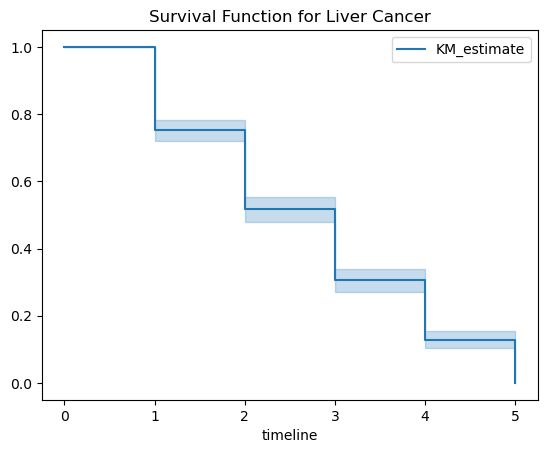

In [41]:
cancer_type = 'Liver'
df_liver = df[df['Cancer Site'] == cancer_type]

kmf = KaplanMeierFitter()
kmf.fit(df_liver['Years Since Diagnosis'], event_observed=(df_liver['Survival (%)'] < 100))

kmf.plot_survival_function()
plt.title(f'Survival Function for {cancer_type} Cancer')
plt.show()

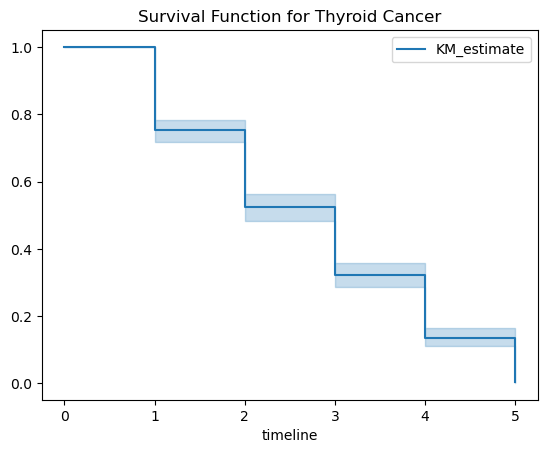

In [39]:
cancer_type = 'Thyroid'
df_thyroid = df[df['Cancer Site'] == cancer_type]

kmf = KaplanMeierFitter()
kmf.fit(df_thyroid['Years Since Diagnosis'], event_observed=(df_thyroid['Survival (%)'] < 100))

kmf.plot_survival_function()
plt.title(f'Survival Function for {cancer_type} Cancer')
plt.show()

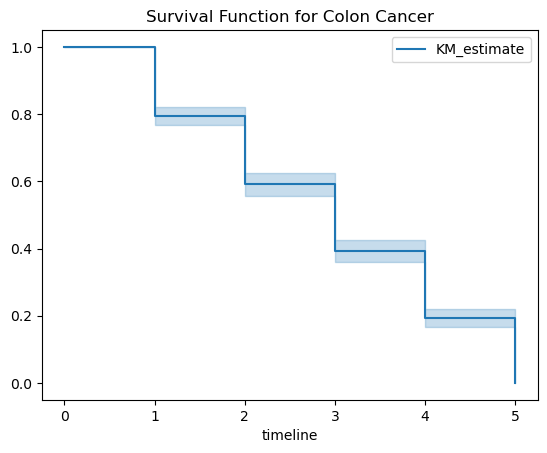

In [40]:
cancer_type = 'Colon'
df_colon = df[df['Cancer Site'] == cancer_type]

kmf = KaplanMeierFitter()
kmf.fit(df_colon['Years Since Diagnosis'], event_observed=(df_colon['Survival (%)'] < 100))

kmf.plot_survival_function()
plt.title(f'Survival Function for {cancer_type} Cancer')
plt.show()

In [11]:
#Random Survival Forest
#dropping non-numeric and low variance columns
df = df.drop(columns=['Geography Type', 'Geography Code', 'Geography Name'])

In [12]:
#Coverting categorical variables to dummy/indicator variables
df = pd.get_dummies(df, columns=['Gender', 'Cancer Site', 'Deprivation Quintile', 'Stage', 'Standardisation Type'], drop_first=True)

In [13]:
#Creating the 'event' column
df['Event'] = df['Survival (%)'] < 100

In [14]:
#Converting 'Event' column to boolean

df['Event'] = df['Event'].astype(bool)

In [15]:
df = df.drop(columns=['Survival (%)', 'Lower 95% CI', 'Upper 95% CI'])


In [16]:
#features (X) and the target (y)

X = df.drop(columns=['Years Since Diagnosis', 'Event'])
y = df[['Years Since Diagnosis', 'Event']]

In [17]:
#target variable y to the required format for scikit-survival

y = np.array([(event, duration) for event, duration in zip(y['Event'], y['Years Since Diagnosis'])],
             dtype=[('event', 'bool'), ('duration', '<f8')])

In [18]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
#Initializing and fitting Random Survival Forest

rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10, min_samples_leaf=15, random_state=42)
rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10, random_state=42)

In [20]:
#Evaluating the model
cindex_train = concordance_index_censored(y_train['event'], y_train['duration'], rsf.predict(X_train))
cindex_test = concordance_index_censored(y_test['event'], y_test['duration'], rsf.predict(X_test))

print(f"Concordance Index (Train): {cindex_train[0]}")
print(f"Concordance Index (Test): {cindex_test[0]}")

Concordance Index (Train): 0.6132679215871621
Concordance Index (Test): 0.5401787127875861


### Interpretation of the Concordance Index:

1) Concordance Index (Train): 0.613

This value indicates that, on the training data, the model has a 61.3% chance of correctly ordering the survival times of any two randomly chosen patients. In other words, the model's predictions are accurate about 61.3% of the time when it comes to the training dataset.

A C-index of 0.5 indicates a model with no predictive power (equivalent to random guessing), while a C-index of 1 indicates a perfectly predictive model.

2) Concordance Index (Test): 0.540

This value indicates that, on the test data, the model has a 54.0% chance of correctly ordering the survival times of any two randomly chosen patients.

A C-index of 0.54 is slightly better than random guessing but indicates that the model's performance on unseen data (test set) is relatively poor and lacks strong predictive accuracy.


### Interpretation of the Results:

- Model Performance: The model's C-index on the training set (0.613) is higher than on the test set (0.540), which suggests that the model fits the training data better than the test data. This might indicate overfitting, where the model learns the training data's patterns but fails to generalize well to new, unseen data.

- Model Improvement: The relatively low C-index on the test set suggests that there is significant room for improvement. Considerations for improving the model could include:

    - Feature Engineering: Creating or selecting more relevant features.
    - Model Tuning: Adjusting hyperparameters or trying different modeling approaches.
    - Data Augmentation: Collecting more data or balancing the dataset if it is imbalanced.